## **Project 1 – Stochastic Programming**

##### Peyton Lewis, Joe Morris, Vivek Dhulipalla, Rianna Patel

**Disclaimer:** We ran our notebook using Gurobi version 9.5.2. 

<br>

#### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from sklearn.linear_model import LinearRegression
from scipy import stats

#### Plot Formatting

In [2]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

#### Read in Data

In [3]:
demand = pd.read_csv('price_demand_data.csv')
demand.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


<br>

### **Task 1: Linear Regression**

In [4]:
def get_regression_output(demand_df) :
    '''
    FUNCTION: fits a linear regression model to the price and demand data
    PARAMETERS: demand dataframe with columns 'price' and 'demand'
    RETURNS: slope, intercept, residuals, model
    '''
    
    # puts the demand and price data into numpy arrays to be used in the regression
    demand_values = demand_df['demand'].values.reshape(-1,1)
    price_values = demand_df['price'].values.reshape(-1,1)

    # fits the linear regression model
    model = LinearRegression()
    model.fit(price_values, demand_values)

    # gets the slope, intercept, and residuals
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]
    residuals = demand_values - model.predict(price_values)

    return slope, intercept, residuals, model

Slope: -1367.71
Intercept: 1924.72



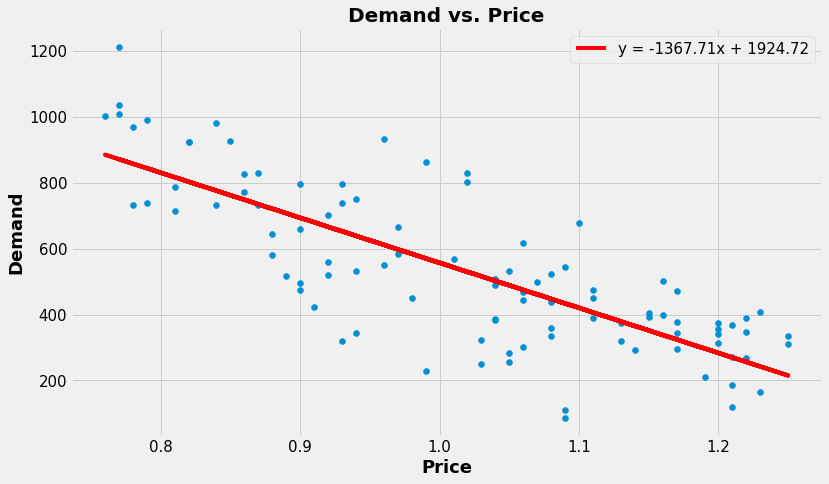

In [5]:
# gets the slope, intercept, and residuals
slope, intercept, residuals, model = get_regression_output(demand)

print('Slope:', slope.round(2))
print('Intercept:', intercept.round(2))
print()

plt.scatter(demand['price'], demand['demand'])
plt.plot(demand['price'], model.predict(demand['price'].values.reshape(-1,1)), color='red')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand vs. Price')
plt.legend(['y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))])
plt.show()


<br>

### **Task 2: Generate Demand Data**

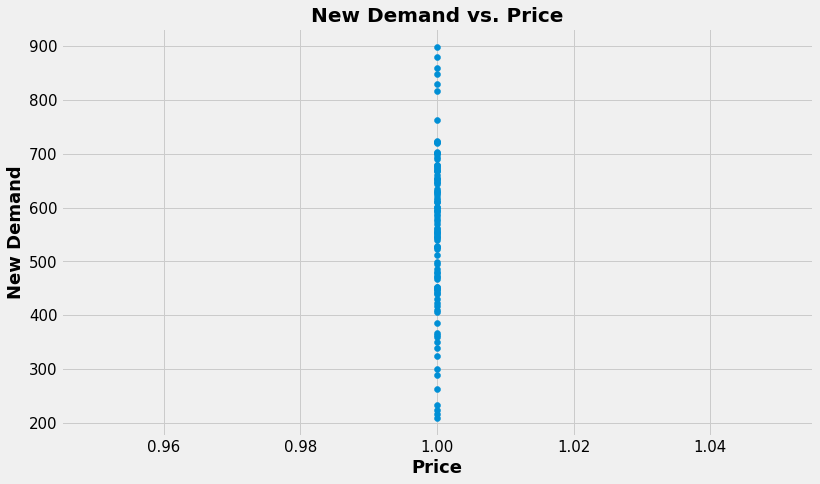

In [6]:
# given parameters
c = 0.5     # cost
g = 0.75    # quick printing cost
t = 0.15    # throw away cost
p = 1       # price

# generate new demand with p = 1
new_demand = intercept + (slope * p) + residuals

plt.scatter(np.array([p]*len(new_demand)), new_demand)
plt.xlabel('Price')
plt.ylabel('New Demand')
plt.title('New Demand vs. Price')
plt.show()

<br>

### **Task 3: Solve LP**

#### Objective Function

$$\max_{q} \frac{1}{n} \sum_{i=1}^{n} \left(pD_i - qc - g\left(D_i - q\right)^+ - t\left(q-D_i\right)^+\right)$$

$$\left(x\right)^+ = \max\left(x,0\right)$$



#### Rewritten Objective Function

$$\max_{q,\ h} \frac{1}{n} \sum_{i=1}^{n} \left(pD_i - qc + h_{i}\right)$$

$$ h_{i} = - g\left(D_i - q\right)^+ - t\left(q-D_i\right)^+ $$

$$\left(x\right)^+ = \max\left(x,0\right)$$

#### Constraints

$$ h_{i} \leq -g(D_{i} - q) $$
$$ h_{i} \leq -t(q - D_{i}) $$
$$ h_{i} \geq -\infty $$
$$ for \ i = 1,2,...,n $$
$$ q \geq 0 $$

In [24]:
# number of days
nd = demand.shape[0] 

# objective
obj = np.zeros(nd+1) 
obj[0] = -c # coefficient of q
obj[1:] = 1.0/nd # coefficient of the h's (to get the average negative cost)

# lower bound
lb = np.zeros(nd+1)
lb[1:] = -np.inf # only p can't be negative

# rhs and direction
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

# constraint matrix
A = np.zeros((2*nd,nd+1))

# fill in the constraint matrix and rhs
for r in range(nd):
    A[2*r,[0,r+1]] = [t,1] # hi <= -t(q - Di)
    rhs[2*r] = t*new_demand[r]
    A[2*r+1,[0,r+1]] = [-g,1] # hi <= -g(Di - q)
    rhs[2*r+1] = -g*new_demand[r]

In [25]:
# solve the LP
lpMod = gp.Model()
lpMod_x = lpMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
lpMod_con = lpMod.addConstr(A @ lpMod_x <= rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
lpMod.setObjective(obj @ lpMod_x + (p * np.mean(new_demand)),sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
lpMod.optimize()

print('Price: $', format(p, '.2f'), sep='')
print('Quantity:', lpMod_x.x[0].round(2))
print('Profit: $', round(lpMod.objval,2), sep='')


Price: $1.00
Quantity: 471.87
Profit: $231.48


<br>

### **Task 4: Solve QP**

#### Objective Function

$$\max_{p, \ q,\ h} \frac{1}{n} \sum_{i=1}^{n} \left(p\left(\beta_{0} + \beta_{1}p + \epsilon_{i}\right) - qc + h_{i}\right)$$

$$ h_{i} = - g\left(D_i - q\right)^+ - t\left(q-D_i\right)^+ $$

$$\left(x\right)^+ = \max\left(x,0\right)$$

#### Constraints

$$ h_{i} \leq -g(\left(\beta_{0} + \beta_{1}p + \epsilon_{i}\right) - q) $$
$$ h_{i} \leq -t(q - \left(\beta_{0} + \beta_{1}p + \epsilon_{i}\right)) $$
$$ 0 \geq h_{i} \geq -\infty $$
$$ for \ i = 1,2,...,n $$
$$ p, \ q \geq 0 $$

In [9]:
def solve_qp(slope, intercept, residuals) :
    '''
    FUNCTION: solves the quadratic program to find the optimal price and quantity
    PARAMETERS: slope: slope of the linear regression model
                intercept: intercept of the linear regression model
                residuals: residuals from the linear regression model
    RETURNS: optimal price, optimal quantity, optimal profit
    '''
    
    # number of decision variables
    m = nd + 1 + 1 

    # Q matrix
    Q = np.zeros((m, m))
    Q[0, 0] = slope # upper left corner is beta 1

    # linear component of objective
    lin = np.zeros(m)
    lin[0] = intercept + np.mean(residuals) # coefficient on p is beta 0 + mean of residuals
    lin[1] = -c # coefficient on q is -c
    lin[2:] = 1.0/nd # coefficient on the h's (to get the average negative cost)

    # upper and lower bounds
    ub = np.zeros(m)
    ub[0:2] = np.inf # h's are zeros while p and q can be infinity
    lb = np.zeros(m)
    lb[2:] = -np.inf # lower bound on h's is -infinity

    # rhs and direction of constraints
    rhs = np.zeros(2*nd)
    direction = np.array(['<']*(2*nd))

    # constraint matrix
    A = np.zeros((2*nd,m))

    # fill in the constraint matrix and rhs
    for r in range(nd):
        A[2*r,[0,1,r+2]] = [-t*slope, t, 1] # hi <= -t(q - (beta0 + beta1*p + e))
        rhs[2*r] = t*(intercept + residuals[r])
        A[2*r+1,[0,1,r+2]] = [g*slope, -g, 1] # hi <= -g((beta0 + beta1*p + e) - q)
        rhs[2*r+1] = -g*(intercept + residuals[r])

    # solve the model
    Mod = gp.Model()
    Mod_x = Mod.addMVar(m, ub=ub, lb=lb)
    Mod_con = Mod.addMConstr(A, Mod_x, direction, rhs)
    Mod.setMObjective(Q, lin, 0, sense=gp.GRB.MAXIMIZE)
    Mod.Params.OutputFlag = 0 

    Mod.optimize()
    
    # get the optimal price, quantity, and profit
    price = Mod_x.x[0]
    quantity = Mod_x.x[1]
    profit = Mod.objval

    return price, quantity, profit

In [10]:
# solve the quadratic program
price, quantity, profit = solve_qp(slope, intercept, residuals)

print('Price: $', format(price, '.2f'), sep='')
print('Quantity:', quantity.round(2))
print('Profit: $', round(profit,2), sep='')

Price: $0.95
Quantity: 535.29
Profit: $234.42


<br>

### **Task 6: Bootstrap Sample - QP**

Slope: -1397.86
Intercept: 1936.67



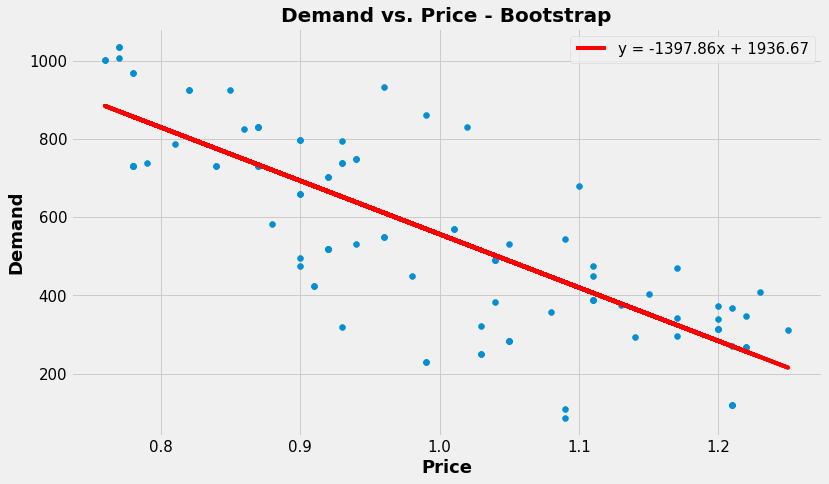

In [11]:
# create a bootstrap sample of the data
bootstrap = np.random.choice(nd, nd, replace=True)
boot_df = demand.iloc[bootstrap]

# get the regression output for the bootstrap sample
slope_boot, intercept_boot, residuals_boot, model_boot = get_regression_output(boot_df)

print('Slope:', slope_boot.round(2))
print('Intercept:', intercept_boot.round(2))
print()

plt.scatter(boot_df['price'], boot_df['demand'])
plt.plot(boot_df['price'], model.predict(boot_df['price'].values.reshape(-1,1)), color='red')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand vs. Price - Bootstrap')
plt.legend(['y = ' + str(round(slope_boot,2)) + 'x + ' + str(round(intercept_boot,2))])
plt.show()

In [12]:
# solve the quadratic program
price_boot, quantity_boot, profit_boot = solve_qp(slope_boot, intercept_boot, residuals_boot)

print('Price: $', format(price_boot, '.2f'), sep='')
print('Quantity:', quantity_boot.round(2))
print('Profit: $', round(profit_boot,2), sep='')

Price: $0.94
Quantity: 503.53
Profit: $226.37


<br>

### **Task 7: Bootstrap Simulations - Price, Quantity, and Profit**

In [13]:
# create a bootstrap sample of the data for 10000 samples
num_samples = 10000

# create arrays to store the results of the bootstrap samples for price, quantity, and profit
price_samples = np.zeros(num_samples)
quantity_samples = np.zeros(num_samples)
profit_samples = np.zeros(num_samples)

# loop through the number of samples
for i in range(num_samples):

    # create a bootstrap sample of the data
    bootstrap_2 = np.random.choice(nd, nd, replace=True)
    boot_df_2 = demand.iloc[bootstrap_2]

    # get the regression output for the bootstrap sample
    slope_boot_2, intercept_boot_2, residuals_boot_2, model_boot_2 = get_regression_output(boot_df_2)

    # solve the QP for the bootstrap sample
    price_boot_2, quantity_boot_2, profit_boot_2 = solve_qp(slope_boot_2, intercept_boot_2, residuals_boot_2)

    # store the results in the arrays in their respective positions
    price_samples[i] = price_boot_2
    quantity_samples[i] = quantity_boot_2
    profit_samples[i] = profit_boot_2

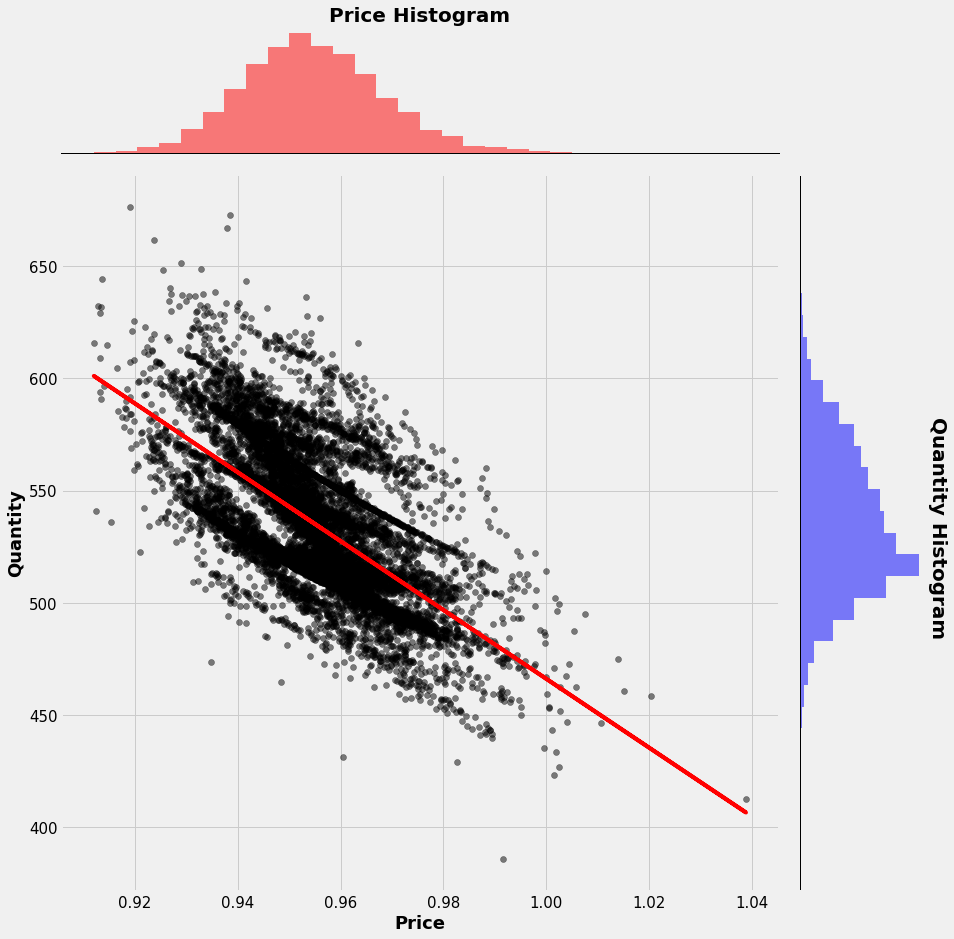

In [14]:
# create the plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15),
                       gridspec_kw={'width_ratios': [2, 0.35],
                                    'height_ratios': [.35, 2]})

# histogram for the Price
ax[0, 0].hist(price_samples, bins=30, color='red', alpha=0.5)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_title('Price Histogram')
ax[0, 0].spines['bottom'].set_color('black')
ax[0, 0].spines['bottom'].set_linewidth(1)


# histogram for the quantity
ax[1, 1].hist(quantity_samples, bins=30, orientation='horizontal', color='blue', alpha=0.5)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].set_title('Quantity Histogram', y=.35, x=1.1)
ax[1, 1].title.set_rotation(-90)
ax[1, 1].spines['left'].set_color('black')
ax[1, 1].spines['left'].set_linewidth(1)

# scatter plot for the price and quantity of all the bootstrap samples
ax[1, 0].scatter(price_samples, quantity_samples, color='black', alpha=0.5)
slope_samples, intercept_samples, residuals_samples, model_samples = get_regression_output(pd.DataFrame({'demand': quantity_samples, 'price': price_samples}))
ax[1, 0].plot(price_samples, model_samples.predict(price_samples.reshape(-1,1)), color='red')
ax[1, 0].set_xlabel('Price')
ax[1, 0].set_ylabel('Quantity')

# remove axis for non used subplots
ax[0, 1].axis('off')

# adjust the subplot positioning
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9,
                    wspace=0.05, hspace=0.05)

plt.show()

In [15]:
# dataframe with the results of the bootstrap samples, mean, std, and 95% confidence interval
results_boot = pd.DataFrame()

# mean and standard deviation
results_boot['Mean'] = [price_samples.mean(), quantity_samples.mean(), profit_samples.mean()]
results_boot['Std'] = [price_samples.std(), quantity_samples.std(), profit_samples.std()]

# t-value and margin of error for 95% confidence interval
t_value_upper = stats.t.ppf(0.975, num_samples-1)
t_value_lower = stats.t.ppf(0.025, num_samples-1)
results_boot['margin error lower'] = [t_value_lower*(price_samples.std()/np.sqrt(num_samples)), t_value_lower*(quantity_samples.std()/np.sqrt(num_samples)), t_value_lower*(profit_samples.std()/np.sqrt(num_samples))]
results_boot['margin error upper'] = [t_value_upper*(price_samples.std()/np.sqrt(num_samples)), t_value_upper*(quantity_samples.std()/np.sqrt(num_samples)), t_value_upper*(profit_samples.std()/np.sqrt(num_samples))]

# 95% confidence interval
results_boot['95% CI Lower'] = results_boot['Mean'] + results_boot['margin error lower']
results_boot['95% CI Upper'] = results_boot['Mean'] + results_boot['margin error upper']

# remove the margin error columns used for calculations
results_boot.drop('margin error lower', axis=1, inplace=True)
results_boot.drop('margin error upper', axis=1, inplace=True)

# add names and format the results
results_boot.index = ['Price', 'Quantity', 'Profit']
results_boot = results_boot.round(4)

results_boot


,Mean,Std,95% CI Lower,95% CI Upper
Price,0.9546,0.0136,0.9543,0.9549
Quantity,535.7825,32.8677,535.1382,536.4268
Profit,235.0254,8.9974,234.8490,235.2017


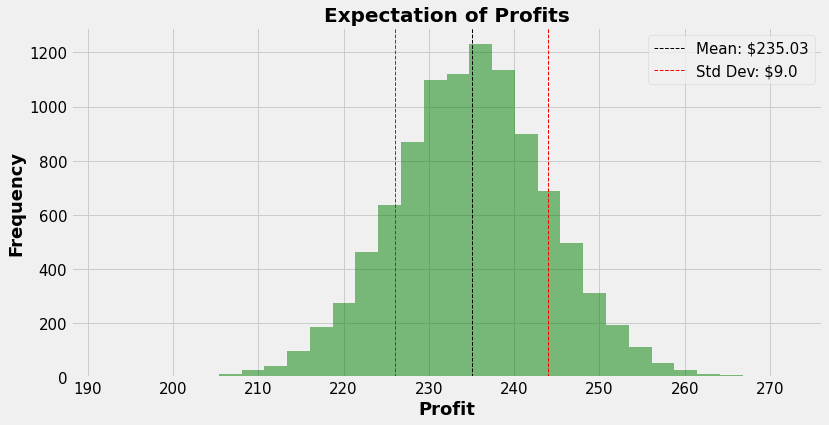

In [16]:
# histogram for the expectation of profits for the bootstrap samples
plt.figure(figsize=(12, 6))
plt.hist(profit_samples, bins=30, color='green', alpha=0.5)
plt.axvline(profit_samples.mean(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(profit_samples.mean() + profit_samples.std(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(profit_samples.mean() - profit_samples.std(), color='red', linestyle='dashed', linewidth=1)
plt.title('Expectation of Profits')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend(['Mean: $' + str(round(profit_samples.mean(),2)), 'Std Dev: $' + str(round(profit_samples.std(),2))])

plt.show()

<br>

### **Task 8: Performance Comparison - NV Model**

#### Objective Function

$$\max_{q} \frac{1}{n} \sum_{i=1}^{n} \left(p\min(q, \ D_i) - qc\right)$$



#### Rewritten Objective Function

$$\max_{h, \ q} \frac{1}{n} \sum_{i=1}^{n} h_{i}$$

#### Constraints

$$ h_{i} \leq pD_{i} - cq $$
$$ h_{i} \leq pq - cq $$
$$ h_{i} \geq -\infty $$
$$ for \ i = 1,2,...,n $$
$$ q \geq 0 $$


#### Part A: Compare to LP

In [17]:
# NV Model - Code provided in class, notebook: 'topic2-sp2.ipynb'

# decision variables are (q, h1, h2, ..., h99)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd

# lower bounds
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

# create rhs and direction for the constraints
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

# create constraint matrix
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [c,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = p*new_demand[r]
    A[2*r+1,[0,r+1]] = [c-p,1]
    rhs[2*r+1] = 0

# solve the model
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addConstr(A @ spMod_x <= rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setObjective(obj @ spMod_x,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

print('Price: $', format(p, '.2f'), sep='')
print('Quantity:', spMod_x.x[0].round(2))
print('Profit: $', round(spMod.objval,2), sep='')

Price: $1.00
Quantity: 569.9
Profit: $219.28


#### Part B: QP Objective Value (Profit) of LP/NV Comparison --> P = 1, Q = LP/NV Q

In [18]:
# using the lp/nv models optimal quantity, a price of $1 to get objective value of QP model
lp_nv_comp_quantity = spMod_x.x[0]
objective = np.zeros(nd)
p = 1

# calculate the objective value for each day
for i in range(nd):
    if lp_nv_comp_quantity <= new_demand[i]:
        objective[i] = (p * new_demand[i]) - (lp_nv_comp_quantity * c) - ((new_demand[i] - lp_nv_comp_quantity) * g)
    else:
        objective[i] = (p * new_demand[i]) - (lp_nv_comp_quantity * c) - ((lp_nv_comp_quantity - new_demand[i]) * t)

# calculate the mean of the objective values which is the expected profit
print('Price: $', format(p, '.2f'), sep='')
print('Quantity:', lp_nv_comp_quantity.round(2))
print('Profit: $', round(objective.mean(),2), sep='')


Price: $1.00
Quantity: 569.9
Profit: $222.63


In [19]:
# aggregate the results into a dataframe
results = pd.DataFrame({'Price':p, 'Quantity':spMod_x.x[0], 'Profit':spMod.objval}, index=['NV Solution (LP Price $1)'])

results.loc['LP Solution'] = [p, lpMod_x.x[0], lpMod.objval]
results.loc['QP Solution'] = [price, quantity, profit]
results.loc['QP Bootstrap Solution'] = [np.mean(price_samples), np.mean(quantity_samples), np.mean(profit_samples)]
results.loc['LP/NV Quantity and QP Objective'] = [p, lp_nv_comp_quantity, objective.mean()]

# change the order of the rows
results = results.reindex(['LP Solution', 'NV Solution (LP Price $1)', 'LP/NV Quantity and QP Objective', 'QP Solution', 'QP Bootstrap Solution'])

# copy the dataframe before formatting for easier plotting
plot_results = results.copy()

# format the results
results['Price'] = results['Price'].apply(lambda x: '$' + format(x, '.2f'))
results['Quantity'] = results['Quantity'].apply(lambda x: format(round(x,2), '.2f'))
results['Profit'] = results['Profit'].apply(lambda x: round(x,2))

results

,Price,Quantity,Profit
LP Solution,$1.00,471.87,231.48
NV Solution (LP Price $1),$1.00,569.90,219.28
LP/NV Quantity and QP Objective,$1.00,569.90,222.63
QP Solution,$0.95,535.29,234.42
QP Bootstrap Solution,$0.95,535.78,235.03


In [21]:
# calc difference between LP/NV Quantity and QP Objective and QP Solution profit

profit_loss = (objective.mean() - profit) / profit
print('The profit loss is ', round(profit_loss * 100, 2), '%', sep='')

profit_gain = (profit - objective.mean()) / objective.mean()
print('The profit gain is ', round(profit_gain * 100, 2), '%', sep='')


The profit loss is -5.03%
The profit gain is 5.3%


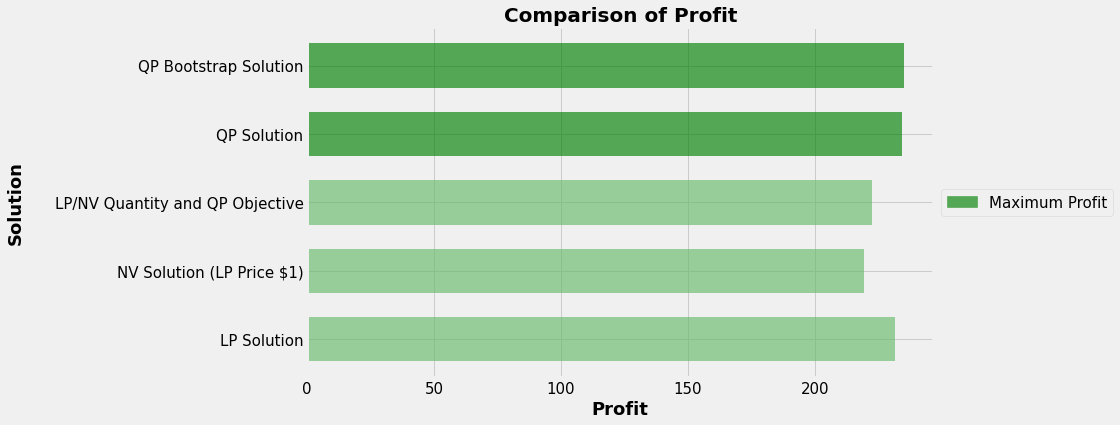

In [22]:
# plot profit for all solutions
profit_results = plot_results.copy()
profit_results = profit_results.drop(['Price', 'Quantity'], axis=1)

plt.figure(figsize=(10,6))
colors = ['#66BB6A', '#66BB6A', '#66BB6A', 'green', 'green']
plt.barh(profit_results.index, profit_results['Profit'], color=colors, alpha=0.65, height=.65)
plt.title('Comparison of Profit')
plt.ylabel('Solution')
plt.gca().yaxis.set_label_coords(-0.45,0.5)
plt.xlabel('Profit')
legend_colors = [plt.Rectangle((0,0),1,1, color='green', alpha=0.65)]
legend = ['Maximum Profit']
plt.legend(legend_colors, legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

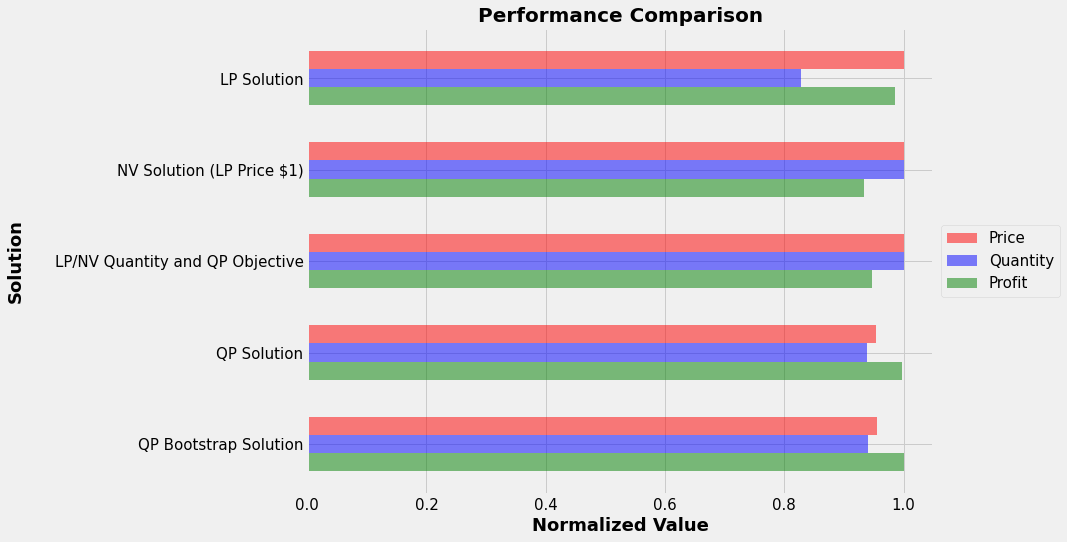

In [23]:
# plot the results normalized
norm_results = plot_results.copy()
norm_results['Price'] = norm_results['Price']/norm_results['Price'].max()
norm_results['Quantity'] = norm_results['Quantity']/norm_results['Quantity'].max()
norm_results['Profit'] = norm_results['Profit']/norm_results['Profit'].max()

norm_results.plot(kind='barh', figsize=(10,8), color=['red','blue','green'], alpha=0.5, width=.6)
plt.gca().invert_yaxis()
plt.title('Performance Comparison')
plt.xlabel('Normalized Value')
plt.ylabel('Solution')
plt.gca().yaxis.set_label_coords(-0.45,0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

